In [1]:
#@formatter:off
%load_ext autoreload
%autoreload 2
#@formatter:on

In [443]:
# need to add src to path
import re
import tqdm
import sys
import pathlib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.join(pathlib.Path('.').parent.resolve(),'..'))
from src import Sampling
from src import SamplingEnums as ENUMS
from src import Metrics, rouge, bleu, perplexity
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer
from datasets import load_dataset
from random import choices
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")

# Utils
functional utility functions to tokenize data
many of these functions serve as lazy generators and are only collected when needed

In [352]:

def gen_n_sent(f, n):
    return list(flatten([f() for _ in range(n)]))

def lword_to_lstr(sentences):
    return (' '.join(s) for s in sentences)

def pprint_sentences(sentences):
    for i, s in enumerate(lword_to_lstr(sentences)):
        print('-' * 100)
        print("{}: {}".format(i, s))

def get_n_random_sentences(sentences, n):
    return choices(sentences, k=n)

def filter_empty_sentences(sentences):
    return (sentence for sentence in sentences if len(sentence) > 0)

def nest_sentences(sentences):
    return ([sentence] for sentence in sentences)

def filter_empty_words(sentences):
    return ([w for w in s if len(w) > 0] for s in sentences)

def flatten(iterables):
    return (elem for iterable in iterables for elem in iterable)

def clean_sentences(sentences):
    return (re.sub(' +', ' ', sentence.replace('\n',' ').replace('\t',' ').replace('\r',' ')) for sentence in sentences)

def split_sentences(sentences):
    return flatten((s.split('.') for s in sentences))

def split_words(sentences):
    return (sentence.split(' ') for sentence in sentences)

def tokenize(sentences):
    return filter_empty_sentences(
                filter_empty_words(
                    split_words(
                        filter_empty_sentences(
                            split_sentences(
                                clean_sentences(sentences))))))

def to_bleu_references(sentences):
    return nest_sentences(sentences)

# Metric requirements
**bleu**
- predictions (list of lists): Translations to score. Each translation should be tokenized into a list of tokens.
- references (list of lists): references for each translation. Each reference should be tokenized into a list of tokens.

```python
>>> predictions = [
...     ["hello", "there", "general", "kenobi"],
...     ["foo", "bar", "foobar"]
... ]
>>> references = [
...     [["hello", "there", "general", "kenobi"]],
...     [["foo", "bar", "foobar"]]
... ]
```

**rouge**
- predictions (list): list of predictions to score. Each prediction should be a string with tokens separated by spaces.
- references (list): list of reference for each prediction. Each reference should be a string with tokens separated by spaces.

```python
>>> predictions = ["hello there", "general kenobi"]
>>> references = ["hello there", "general kenobi"]
```

**perplexity**
- input_texts (list of str): input text, each separate text snippet is one list entry.
```python
>>> input_texts = ["lorem ipsum", "Happy Birthday!", "Bienvenue"]
```

# Load model and datasets

In [303]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# add the EOS token as PAD token to avoid warnings
model = TFGPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

# encode context the generation is conditioned on
input_ids = tokenizer.encode('I enjoy walking with my cute dog', return_tensors='tf')

references = list(tokenize(load_dataset("wikitext", "wikitext-2-raw-v1", split="train")['text']))

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
Reusing dataset wikitext (/Users/hp/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


# Peek at refrence sentences

In [353]:
s = get_n_random_sentences(references, 3)
print('=' * 100)
print('{:^100s}'.format("REFRENCES"))
pprint_sentences(s)
print('=' * 100)


                                             REFRENCES                                              
----------------------------------------------------------------------------------------------------
0: In the Treaty of Saint @-@ Germain @-@ en @-@ Laye , the transfer was not recognized ; instead , Zrínyi was given to Italy and broken up for scrap
----------------------------------------------------------------------------------------------------
1: By 24 June , the uprising had reached a massive scale across eastern Herzegovina , with between 1 @,@ 500 and 3 @,@ 000 armed rebels in total , including some Montenegrins
----------------------------------------------------------------------------------------------------
2: Members of the special forces battalion have benefitted from courses abroad , such as the US Army Special Forces ( Green Berets ) course , the United States Marine Corps Force Recon course , as well as other courses


# generate some sequences

In [359]:

def generate_all_sampling(sampling, input_ids, tokenizer, num_gen=1, seed=None):
    greedy = gen_n_sent(lambda: sampling.print(input_ids, ENUMS.GREEDY, tokenizer, max_length=50, quiet=True), num_gen)
    beam = gen_n_sent(lambda: sampling.print(input_ids, ENUMS.BEAM, tokenizer, quiet=True), num_gen)
    random = gen_n_sent(lambda: sampling.print(input_ids, ENUMS.RANDOM, tokenizer, seed=seed, quiet=True), num_gen)
    top_k = gen_n_sent(lambda: sampling.print(input_ids, ENUMS.TOP_K, tokenizer, seed=seed, quiet=True), num_gen)
    top_p = gen_n_sent(lambda: sampling.print(input_ids, ENUMS.TOP_P, tokenizer, seed=seed, quiet=True), num_gen)
    return greedy, beam, random, top_k, top_p

In [356]:
num_gen=1  # number of sentences to generate
seed=None  # seed for sampling that needs randomness
sampling = Sampling(model)
greedy, _, _, _, _ = generate_all_sampling(sampling, input_ids, tokenizer, num_gen, seed)

# get metrics (The long way)

In [398]:
# we will store the results of all metrics in a dictionary that will be ported to a pandas df at some point
metric_values = {}
# get predictions and random references
predictions = list(tokenize(greedy))
predict_len = len(predictions)
n_references = get_n_random_sentences(references, predict_len)
pprint_sentences(n_references)

----------------------------------------------------------------------------------------------------
0: Two of the stories were by R
----------------------------------------------------------------------------------------------------
1: Olivia admits to Walter how she found the address and learns that her brain still contains some of John 's memories
----------------------------------------------------------------------------------------------------
2: The Independent State of Croatia ( NDH ) was founded on 10 April 1941 , during the invasion of Yugoslavia by the Axis powers


# BLEU
```python
>>> predictions = [
...     ["hello", "there", "general", "kenobi"],
...     ["foo", "bar", "foobar"]
... ]
>>> references = [
...     [["hello", "there", "general", "kenobi"]],
...     [["foo", "bar", "foobar"]]
... ]
```

In [330]:
bleu_pred = bleu.compute(predictions=predictions, references=list(to_bleu_references(n_references)))
metric_values.update(bleu_pred)

# ROUGE
```python
>>> predictions = ["hello there", "general kenobi"]
>>> references = ["hello there", "general kenobi"]
```

In [340]:
rouge_pred = rouge.compute(predictions=lword_to_lstr(predictions), references=lword_to_lstr(n_references))
metric_values.update(rouge_pred)


# PERPLEXITY
```python
input_texts = ["lorem ipsum", "Happy Birthday!", "Bienvenue"]
```

In [344]:
perp_pred = perplexity.compute(input_texts=lword_to_lstr(predictions), model_id='gpt2')
metric_values.update(perp_pred)

Using pad_token, but it is not set yet.


  0%|          | 0/1 [00:00<?, ?it/s]

In [345]:
pprint(metric_values)

{'bleu': 0.0,
 'brevity_penalty': 0.48775174689448264,
 'length_ratio': 0.582089552238806,
 'mean_perplexity': 5.2147213617960615,
 'perplexities': [6.170468330383301,
                  4.877141952514648,
                  4.596553802490234,
                  6.170468330383301,
                  4.877141952514648,
                  4.596553802490234,
                  6.170468330383301,
                  4.877141952514648,
                  4.596553802490234],
 'precisions': [0.06837606837606838, 0.0, 0.0, 0.0],
 'prompt_id': 0,
 'reference_length': 201,
 'rouge1': AggregateScore(low=Score(precision=0.028111341154819416, recall=0.022100474784653535, fmeasure=0.023418223418223416), mid=Score(precision=0.06892109500805153, recall=0.04856989494670654, fmeasure=0.05456464535748423), high=Score(precision=0.11595698182654703, recall=0.07678291861564808, fmeasure=0.08797746778565192)),
 'rouge2': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.0, recal

# Condensed function for metrics

In [399]:
def get_metrics(predictions, references):
    # tokenize the input texts and get reference texts
    predictions = list(tokenize(predictions))
    predict_len = len(predictions)
    n_references = get_n_random_sentences(references, predict_len)

    # get metrics
    metric_values = {}
    metric_values.update(bleu.compute(predictions=predictions, references=list(to_bleu_references(n_references))))
    metric_values.update(rouge.compute(predictions=lword_to_lstr(predictions), references=lword_to_lstr(n_references)))
    metric_values.update(perplexity.compute(input_texts=lword_to_lstr(predictions), model_id='gpt2'))

    return metric_values

In [350]:
pprint(get_metrics(greedy, references))

Using pad_token, but it is not set yet.


  0%|          | 0/1 [00:00<?, ?it/s]

{'bleu': 0.0,
 'brevity_penalty': 0.5544694381597404,
 'length_ratio': 0.6290322580645161,
 'mean_perplexity': 5.2147213617960615,
 'perplexities': [6.170468330383301,
                  4.877141952514648,
                  4.596553802490234,
                  6.170468330383301,
                  4.877141952514648,
                  4.596553802490234,
                  6.170468330383301,
                  4.877141952514648,
                  4.596553802490234],
 'precisions': [0.042735042735042736, 0.0, 0.0, 0.0],
 'prompt_id': 0,
 'reference_length': 186,
 'rouge1': AggregateScore(low=Score(precision=0.007407407407407408, recall=0.007936507936507936, fmeasure=0.007168458781362007), mid=Score(precision=0.026731078904991948, recall=0.03396093662051109, fmeasure=0.027529706728816845), high=Score(precision=0.05088566827697263, recall=0.06296873241022176, fmeasure=0.048195372561920184)),
 'rouge2': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.0, r

# Automate process

In [400]:
def tokenize_prompts(prompts, tokenizer):
    return {i: tokenizer.encode(prompt, return_tensors='tf') for i, prompt in enumerate(prompts)}

def get_metrics_for_all_sampling(sampling, input_ids, tokenizer, references, num_gen=1, seed=None):
    greedy, beam, random, top_k, top_p = generate_all_sampling(sampling, input_ids, tokenizer, num_gen, seed)
    return {
        'greedy': get_metrics(greedy, references),
        'beam': get_metrics(beam, references),
        'random': get_metrics(random, references),
        'top_k': get_metrics(top_k, references),
        'top_p': get_metrics(top_p, references)
    }

def get_metrics_for_all_prompts(sampling, prompts, tokenizer, references, num_gen, seed):
    metrics = {}
    for i, prompt in tqdm.tqdm(prompts.items()):
        metrics[i] = get_metrics_for_all_sampling(sampling, prompt, tokenizer, references, num_gen, seed)
    return metrics

In [401]:
num_gen=1  # number of sentences to generate
seed=None  # seed for sampling that needs randomness
sampling = Sampling(model)

prompts = [
    'I enjoy walking with my cute dog',
    'My favorite color is blue but',
    'Alan turing is a great scientist and he',
]
prompts = tokenize_prompts(prompts,tokenizer)


In [402]:
metrics = get_metrics_for_all_prompts(sampling, prompts, tokenizer, references, num_gen, seed)


  0%|          | 0/3 [00:00<?, ?it/s]Using pad_token, but it is not set yet.


  0%|          | 0/1 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


  0%|          | 0/1 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


  0%|          | 0/1 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


  0%|          | 0/1 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


  0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:44<01:28, 44.39s/it]Using pad_token, but it is not set yet.


  0%|          | 0/1 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


  0%|          | 0/1 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


  0%|          | 0/1 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


  0%|          | 0/1 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


  0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [01:25<00:42, 42.57s/it]Using pad_token, but it is not set yet.


  0%|          | 0/1 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


  0%|          | 0/1 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


  0%|          | 0/1 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


  0%|          | 0/1 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 3/3 [02:05<00:00, 41.97s/it]


In [403]:
metrics

{0: {'greedy': {'bleu': 0.0,
   'precisions': [0.02564102564102564, 0.0, 0.0, 0.0],
   'brevity_penalty': 0.5404329964865341,
   'length_ratio': 0.6190476190476191,
   'translation_length': 39,
   'reference_length': 63,
   'rouge1': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.014492753623188406, recall=0.013333333333333334, fmeasure=0.013888888888888888), high=Score(precision=0.043478260869565216, recall=0.04, fmeasure=0.041666666666666664)),
   'rouge2': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.0, recall=0.0, fmeasure=0.0), high=Score(precision=0.0, recall=0.0, fmeasure=0.0)),
   'rougeL': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.014492753623188406, recall=0.013333333333333334, fmeasure=0.013888888888888888), high=Score(precision=0.043478260869565216, recall=0.04, fmeasure=0.041666666666666664)),
   'rougeLsum': AggregateScore(low=Score(precisio

# Convert metrics to dataframe

In [424]:
def metric_dict_to_df(metrics):
    cols = ['prompt_id', 'sampling_type'] + list(metrics[0]['greedy'].keys())
    df = pd.DataFrame(columns=cols)
    for i, metric_dict in metrics.items():
        for sampling_type, metric_values in metric_dict.items():
            row = {'prompt_id': i, 'sampling_type': sampling_type}
            row.update(metric_values)
            df = df.append(row, ignore_index=True)
    return df


In [428]:
metric_df = metric_dict_to_df(metrics)
print(metric_df.head())


  prompt_id sampling_type bleu                            precisions  \
0         0        greedy  0.0  [0.02564102564102564, 0.0, 0.0, 0.0]   
1         0          beam  0.0  [0.07692307692307693, 0.0, 0.0, 0.0]   
2         0        random  0.0  [0.02564102564102564, 0.0, 0.0, 0.0]   
3         0         top_k  0.0                  [0.0, 0.0, 0.0, 0.0]   
4         0         top_p  0.0                [0.175, 0.0, 0.0, 0.0]   

  brevity_penalty length_ratio translation_length reference_length  \
0        0.540433     0.619048                 39               63   
1        0.135335     0.333333                 39              117   
2        0.256924     0.423913                 39               92   
3             1.0         12.0                 36                3   
4        0.272532     0.434783                 40               92   

                                              rouge1  \
0  ((0.0, 0.0, 0.0), (0.014492753623188406, 0.013...   
1  ((0.0, 0.0, 0.0), (0.0512077294

## Plotting Mean Perplexities

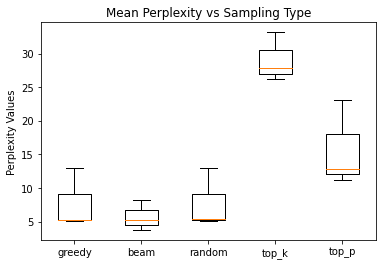

In [441]:
sampling_types = ['greedy', 'beam', 'random', 'top_k', 'top_p']
perplexity_values = []
for t in sampling_types:
    perplexity_values.append(metric_df[metric_df['sampling_type'] == t]['mean_perplexity'].to_numpy())
fig, ax = plt.subplots()
plt.title('Mean Perplexity vs Sampling Type')
ax.boxplot(perplexity_values)
ax.set_xticklabels(sampling_types)
plt.ylabel('Perplexity Values')
plt.show()

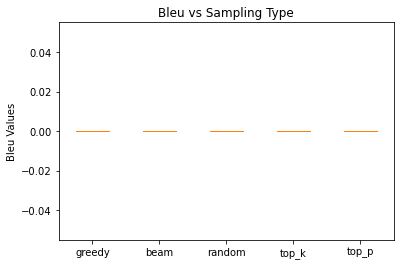

In [442]:
sampling_types = ['greedy', 'beam', 'random', 'top_k', 'top_p']
bleu_values = []
for t in sampling_types:
    bleu_values.append(metric_df[metric_df['sampling_type'] == t]['bleu'].to_numpy())
fig, ax = plt.subplots()
plt.title('Bleu vs Sampling Type')
ax.boxplot(bleu_values)
ax.set_xticklabels(sampling_types)
plt.ylabel('Bleu Values')
plt.show()